<a href="https://colab.research.google.com/github/PreyPython123/Master-V24-Semiveiledet-Regresjon/blob/Databehandling-Pradeep/Bioco_Databehandling_av_ekstremverdier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lasting av nødvendige pakker og bibliotek

In [1]:
! pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.3-py3-none-any.whl size=190250 sha256=e5cccd033301a81b6d1bb4ec7f18ad670d33ba392b9a07b30731fcec5c3ead06
  Stored in directory: /root/.cache/pip/wheels/05/f8/db/124d43bec122d6ec0ab3713fadfe25ebed8af52ec561682b4e
Successfully built pyod


Importering av nødvendige pakker og bibliotek

In [2]:
import pandas as pd
import numpy as np
import copy
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns


from pyod.models.hbos import HBOS
from pyod.models.cblof import CBLOF

from sklearn.cluster import DBSCAN

Importering av data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Velger første kolonne med dato og tid som index
behandlet_data = pd.read_csv('/content/drive/MyDrive/MasterV24/Bioco_data/manglende_data_behandlet_bioco_data.csv',
                             header=0,
                             sep=',',
                             index_col=0)

# Formatterer index til riktig format og datatype
behandlet_data.index = pd.to_datetime(behandlet_data.index,
                                      format='%Y-%m-%d %H:%M:%S')

Mounted at /content/drive


# Undersøkelse av data før behandling for ekstreme verdier

In [4]:
behandlet_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   29136 non-null  int64  
 1   EnzymeType_A2   29136 non-null  int64  
 2   EnzymeType_B    29136 non-null  int64  
 3   EnzymeType_C    29136 non-null  int64  
 4   EnzymeType_D    29136 non-null  int64  
 5   EnzymeType_E    29136 non-null  int64  
 6   RawMatPercent   29136 non-null  float64
 7   NIRfat          29136 non-null  float64
 8   NIRash          29136 non-null  float64
 9   NIRwater        29136 non-null  float64
 10  TT08            29136 non-null  float64
 11  TT20            29136 non-null  float64
 12  TT12            29136 non-null  float64
 13  Collagen        89 non-null     float64
 14  Mw              460 non-null    float64
 15  SmallMolecules  460 non-null    float64
 16  BrixAdjusted    460 non-null    float64
d

# Inspeksjon av mulige ekstremverdier

Henter prediktorer verdiene som skal undersøkes

In [5]:
# Utelukker data fra kategoriske variabler for inspeksjon
prediktor_data = behandlet_data.iloc[:, 6:-4]

# Henter ut kun verdier for undersøkelse
X = prediktor_data.values

# Informasjon om data som skal undersøkes
prediktor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29136 entries, 2022-10-31 17:37:00 to 2023-06-14 01:06:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  29136 non-null  float64
 1   NIRfat         29136 non-null  float64
 2   NIRash         29136 non-null  float64
 3   NIRwater       29136 non-null  float64
 4   TT08           29136 non-null  float64
 5   TT20           29136 non-null  float64
 6   TT12           29136 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB


## Violin plot

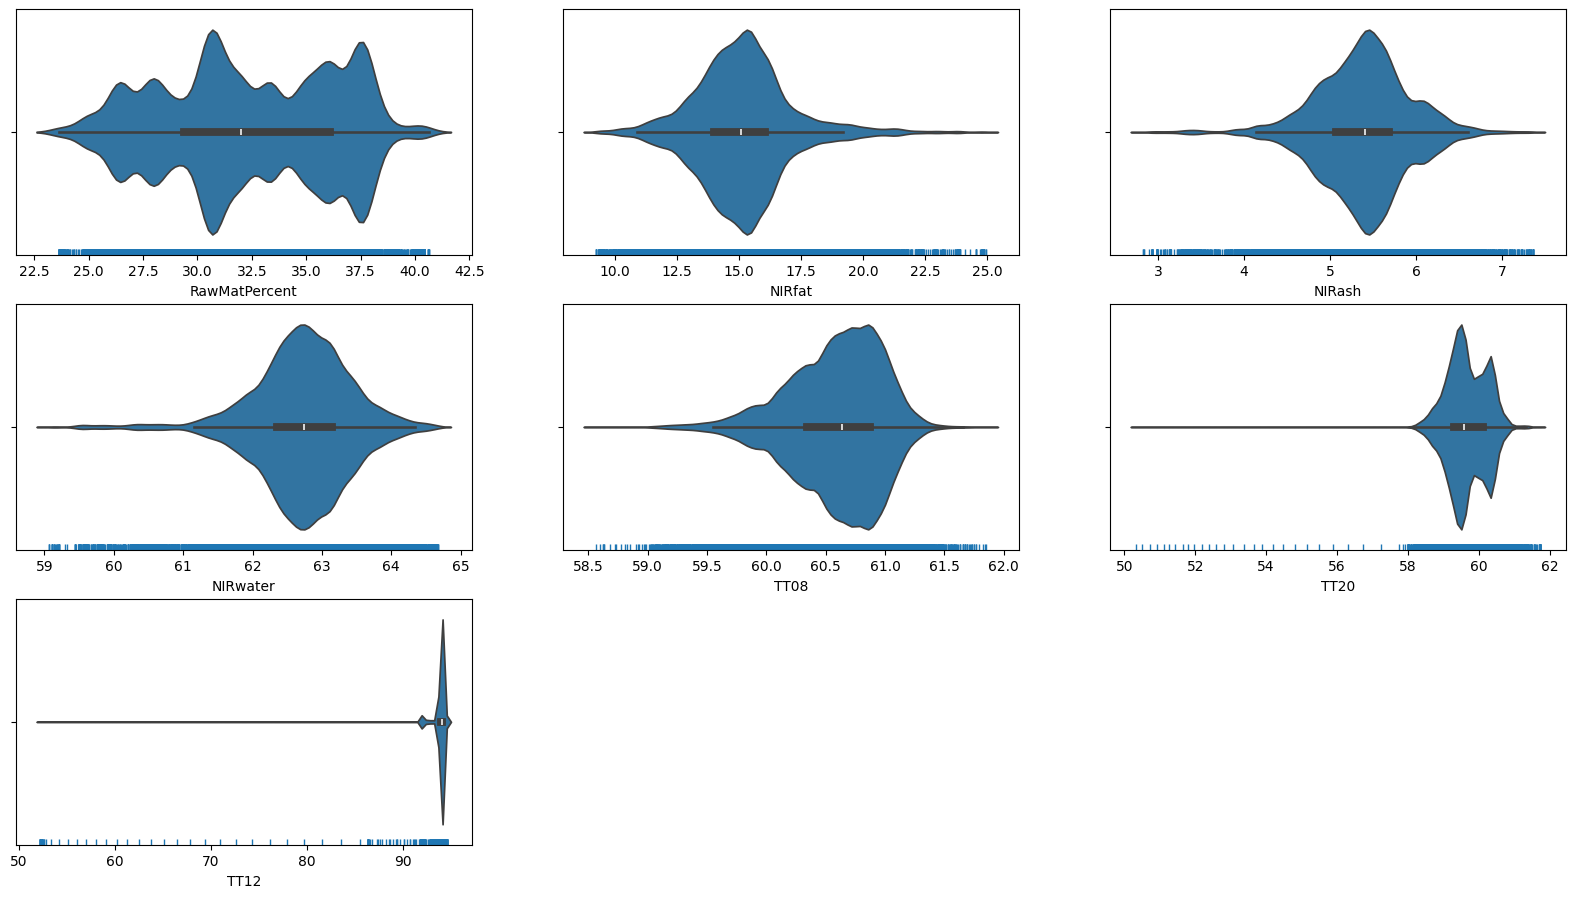

In [6]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(prediktor_data.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), prediktor_data):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = prediktor_data)
  sns.rugplot(x=prediktor_data[indeks])
  i += 1

## PCA analyse?

#Ekstremverdi inspeksjon med HBOS

<ipython-input-7-4459c12e3d90>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-7-4459c12e3d90>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


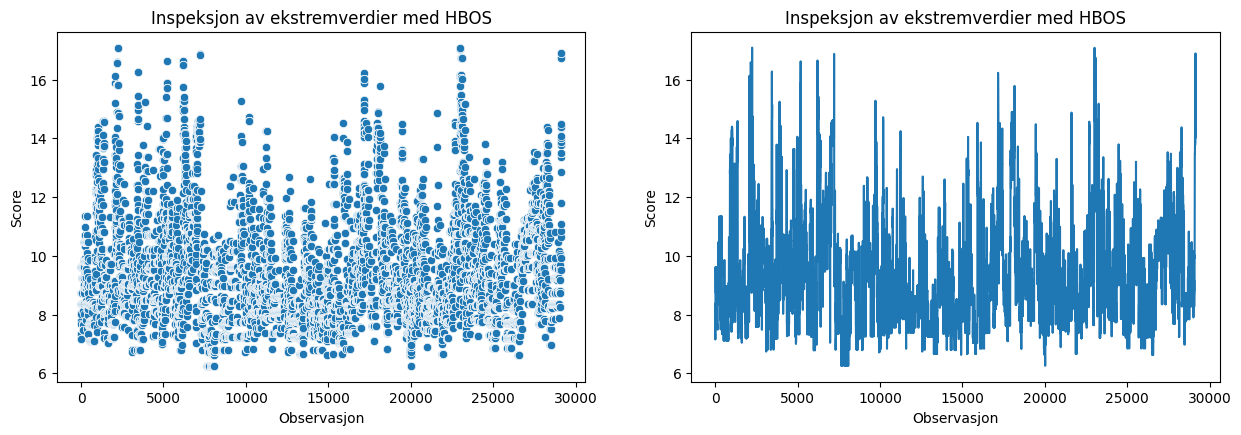

In [7]:
# Ekstremverdi inspeksjon med HBOS på data
hbos = HBOS()
hbos.fit(X)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_hbos = hbos.labels_
y_scores_hbos = hbos.decision_scores_

# Plotter observasjoner med tilhørende score
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data=y_scores_hbos)
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med HBOS")

plt.subplot(2,2,2)
plt.plot(list(y_scores_hbos))
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med HBOS")
plt.show()

Data etter behandling av ekstremdata med HBOS

In [85]:
#Setter terskel på score som anses som ekstrem observasjon
terskel_hbos = 11

# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_hbos_indeks = np.where(y_scores_hbos > terskel_hbos)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_hbos_terskel = prediktor_data.iloc[mulige_ekstrem_hbos_indeks]

# Utelukker ekstreme observasjoner fra data
behandlet_data_hbos = prediktor_data.drop(prediktor_data.index[mulige_ekstrem_hbos_indeks])

# Data etter inspeksjon med HBOS
print("Data etter HBOS:")
print(behandlet_data_hbos.info())

Data etter HBOS:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24285 entries, 2022-10-31 17:37:00 to 2023-06-14 00:15:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  24285 non-null  float64
 1   NIRfat         24285 non-null  float64
 2   NIRash         24285 non-null  float64
 3   NIRwater       24285 non-null  float64
 4   TT08           24285 non-null  float64
 5   TT20           24285 non-null  float64
 6   TT12           24285 non-null  float64
dtypes: float64(7)
memory usage: 1.5 MB
None


Violin plot

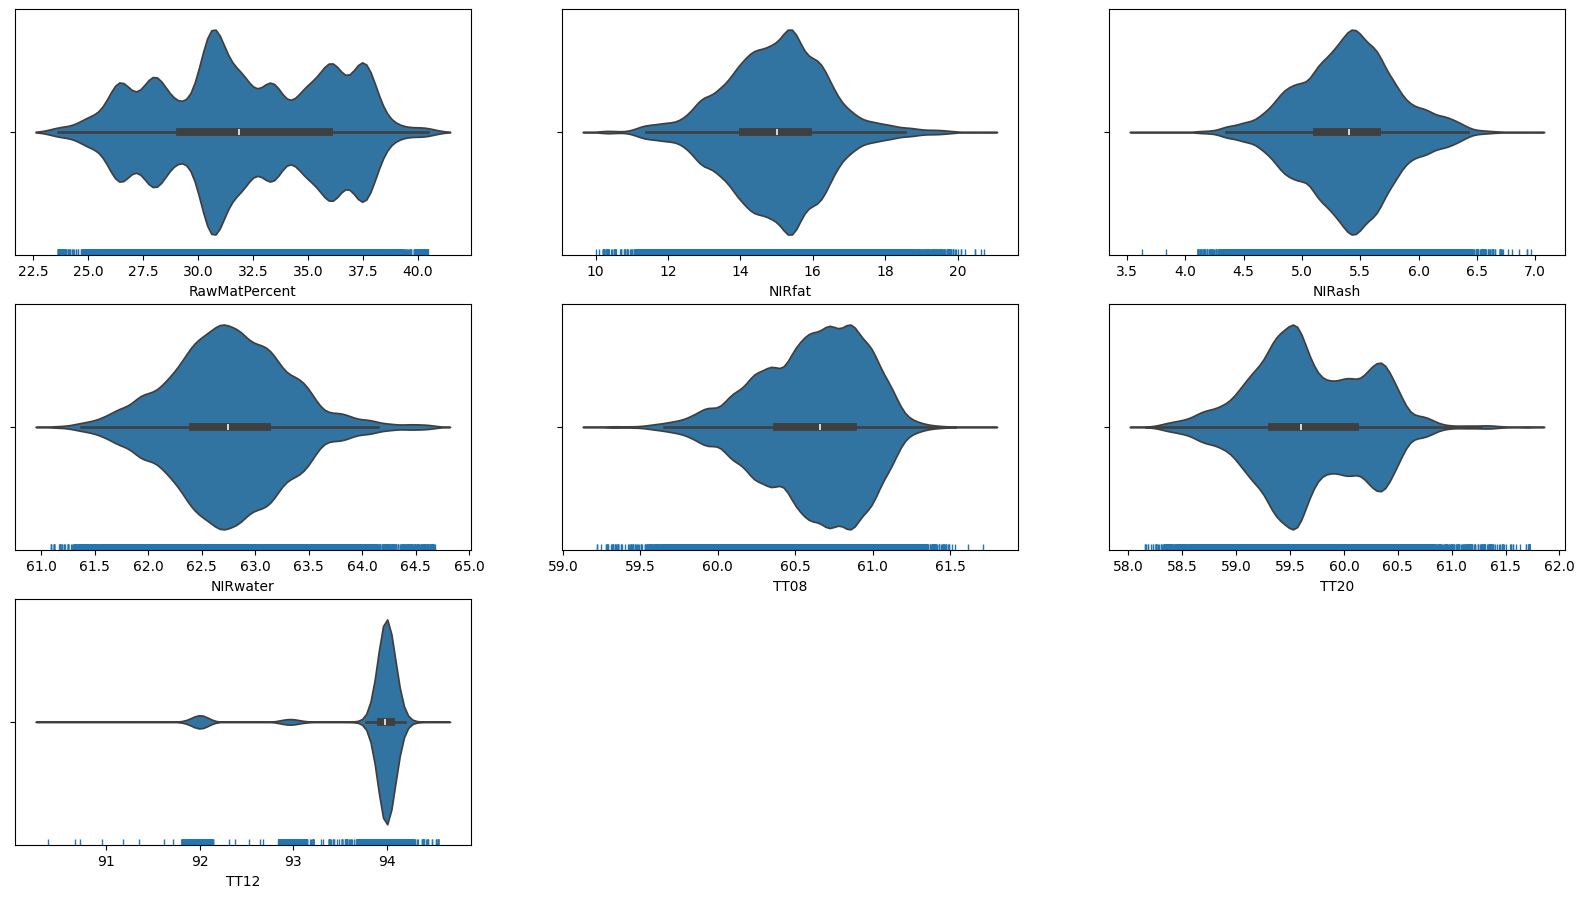

In [77]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_hbos.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_hbos):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_hbos)
  sns.rugplot(x=behandlet_data_hbos[indeks])
  i += 1

# Ekstremsverdi inspeksjon med CBLOF

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-13-49a01b1d3dad>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,1)
<ipython-input-13-49a01b1d3dad>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,2,2)


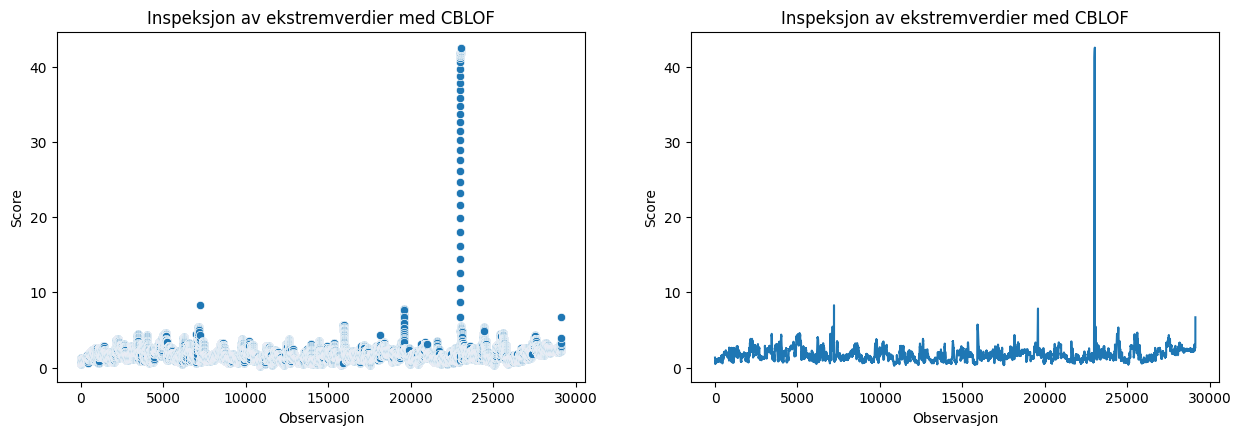

In [13]:
# Ektremverdiinspeksjon med CBLOF på data
cblof = CBLOF()
cblof.fit(X)

# Predikerer mulige ekstreme observasjoner, samt score
y_predikert_cblof = cblof.labels_
y_scores_cblof = cblof.decision_scores_

# Plotter observasjoner med tilhørende score
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
plt.subplot(2,2,1)
sns.scatterplot(data=y_scores_cblof)
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med CBLOF")

plt.subplot(2,2,2)
plt.plot(list(y_scores_cblof))
plt.xlabel('Observasjon')
plt.ylabel('Score')
plt.title("Inspeksjon av ekstremverdier med CBLOF")
plt.show()

Data etter behandling av ekstrem data med CBLOF

In [113]:
#Setter terskel på score som anses som ekstrem observasjon
terskel_cblof = 5

# Henter indeks til mulige ektreme observasjoner med score over terskel
mulige_ekstrem_cblof_indeks = np.where(y_scores_cblof > terskel_cblof)[0]

# Henter mulige ekstreme obersjoner over satt terskel fra data
mulige_ektrem_cblof_terskel = prediktor_data.iloc[mulige_ekstrem_cblof_indeks]

# Utelukker ekstreme observasjoner fra data
behandlet_data_cblof = prediktor_data.drop(prediktor_data.index[mulige_ekstrem_cblof_indeks])

# Data etter inspeksjon med CBLOF
print("Data etter CBLOF:")
print(behandlet_data_cblof.info())

Data etter CBLOF:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28967 entries, 2022-10-31 17:37:00 to 2023-06-14 01:05:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  28967 non-null  float64
 1   NIRfat         28967 non-null  float64
 2   NIRash         28967 non-null  float64
 3   NIRwater       28967 non-null  float64
 4   TT08           28967 non-null  float64
 5   TT20           28967 non-null  float64
 6   TT12           28967 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB
None


Violin plot

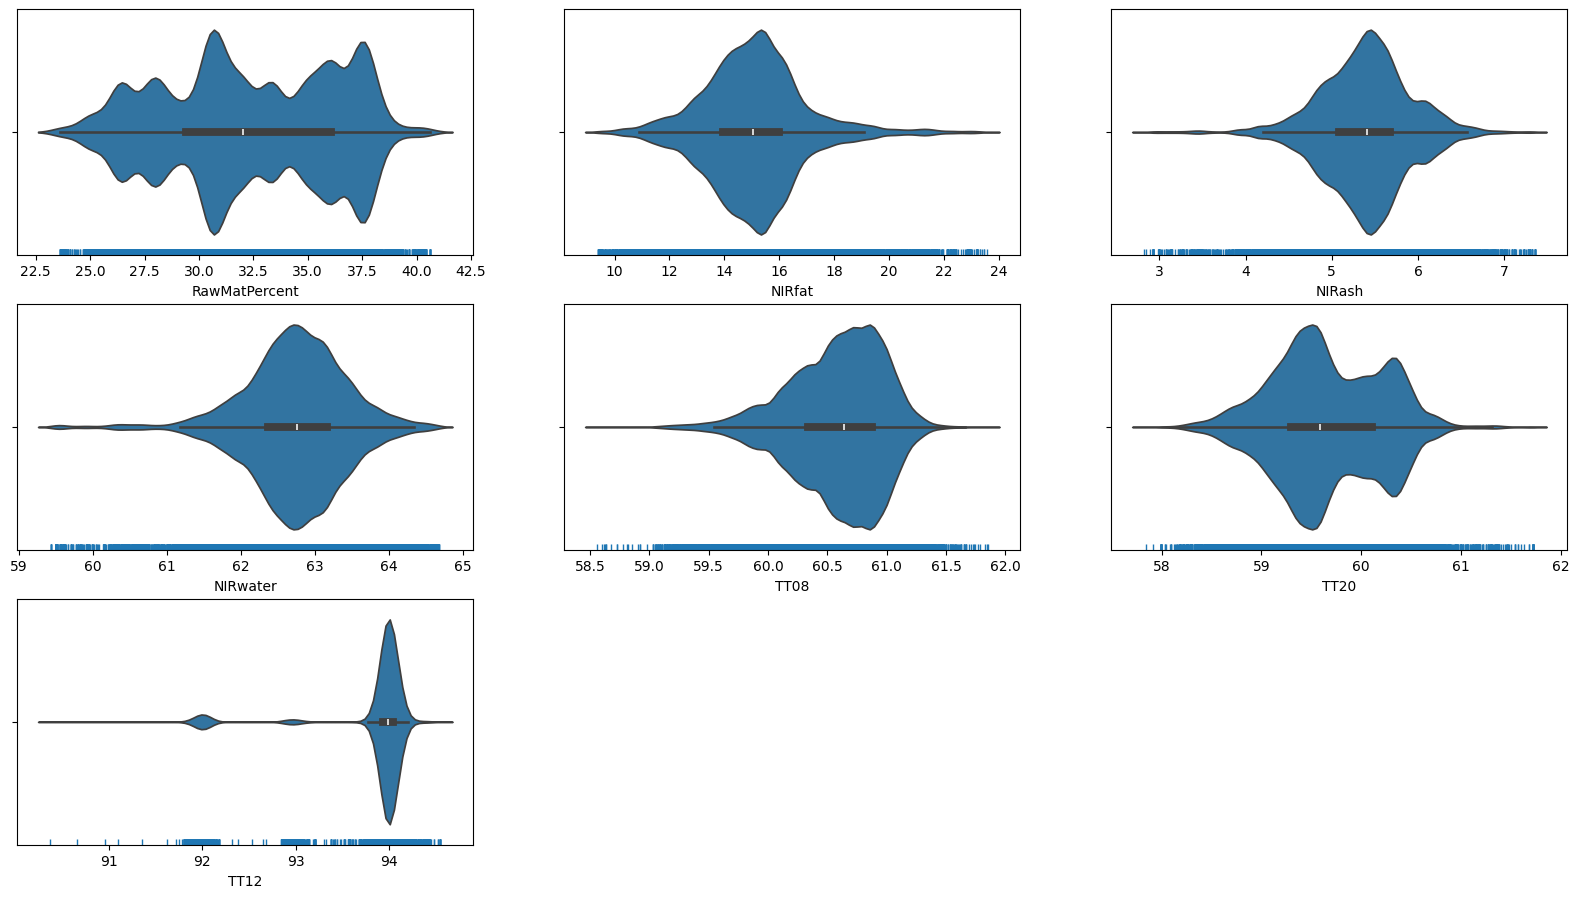

In [60]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_cblof.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_cblof):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_cblof)
  sns.rugplot(x=behandlet_data_cblof[indeks])
  i += 1

# Ekstremverdi inspeksjon med DBSCAN

In [101]:
# Parametere for DBSCAN
eps = 0.5
min_observasjoner = 10

# DBSCAN modell
dbscan_model = DBSCAN(eps=eps, min_samples=min_observasjoner)
dbscan_model.fit(X)

# Henter labels, -1 markert som ekstrem observasjon
y_predikert_dbscan = dbscan_model.labels_

mulige_ekstrem_dbscan_indeks = np.where(y_predikert_dbscan == -1)[0]
# Filtrerer bort ekstreme observasjoner
behandlet_data_dbscan = prediktor_data[y_predikert_dbscan != -1]

# Data etter inspeksjon med HBOS
print("Data etter DSCAN:")
print(behandlet_data_dbscan.info())

Data etter DSCAN:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28350 entries, 2022-10-31 17:37:00 to 2023-06-14 00:58:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  28350 non-null  float64
 1   NIRfat         28350 non-null  float64
 2   NIRash         28350 non-null  float64
 3   NIRwater       28350 non-null  float64
 4   TT08           28350 non-null  float64
 5   TT20           28350 non-null  float64
 6   TT12           28350 non-null  float64
dtypes: float64(7)
memory usage: 1.7 MB
None


Violin plot

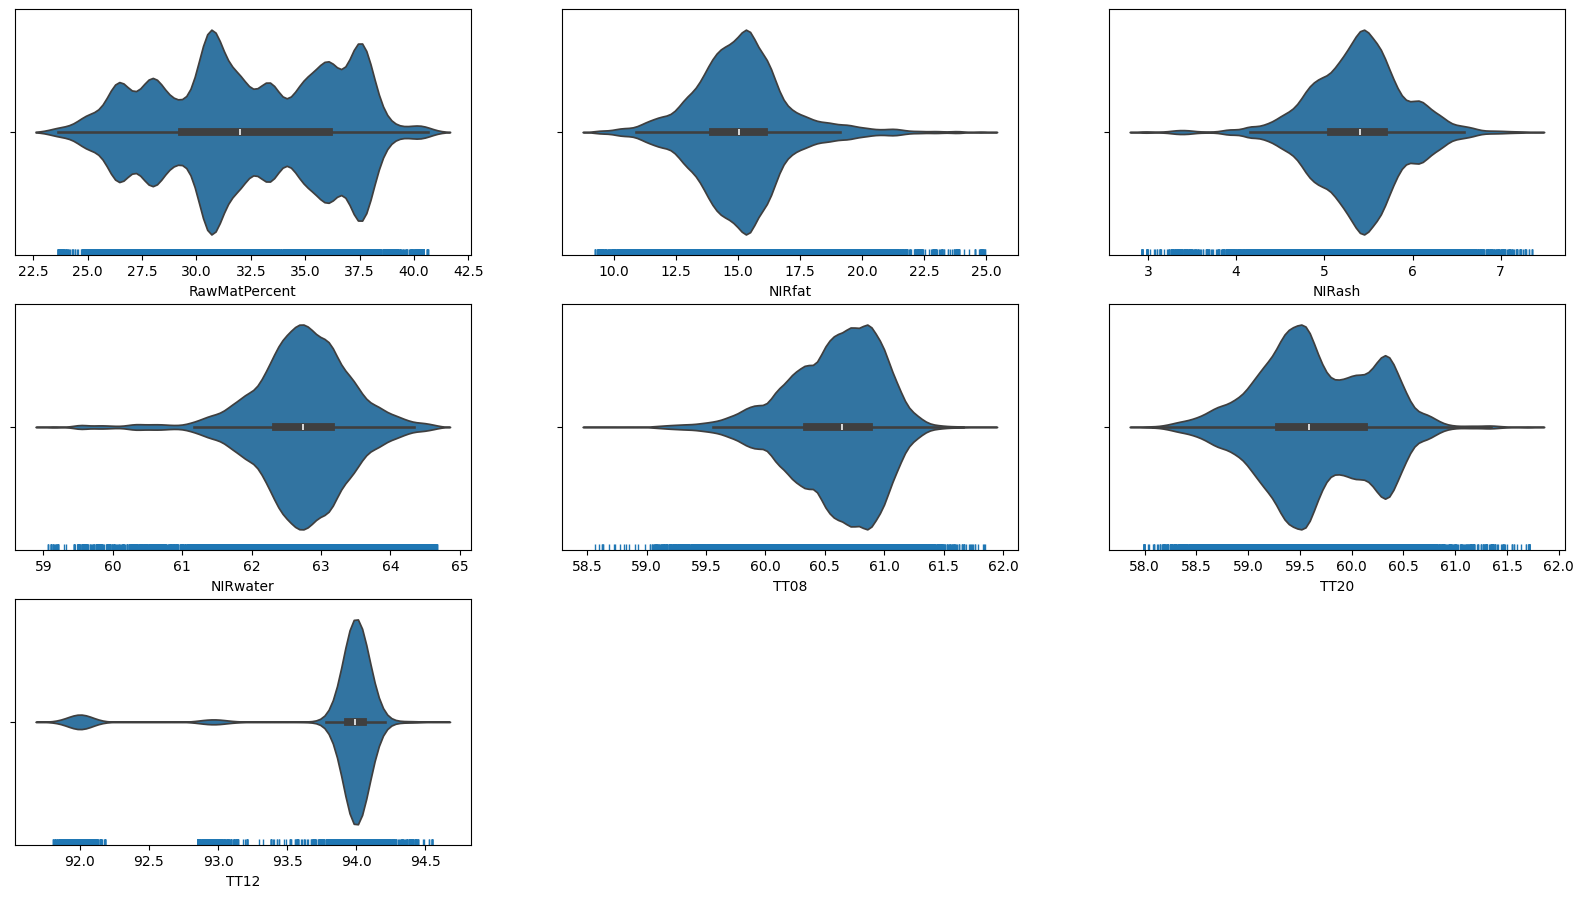

In [62]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(behandlet_data_dbscan.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), behandlet_data_dbscan):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = behandlet_data_dbscan)
  sns.rugplot(x=behandlet_data_dbscan[indeks])
  i += 1

# Samlet behandling av ekstrem data

In [114]:
# Finner ektreme observasjoner som er felles for inspeksjonene
samlet_ekstrem_indeks = np.intersect1d(mulige_ekstrem_hbos_indeks, mulige_ekstrem_cblof_indeks)

samlet_ekstrem_indeks = np.intersect1d(samlet_ekstrem_indeks, mulige_ekstrem_dbscan_indeks)


# Remove the common outliers from the original DataFrame
prediktor_data_ekstrem = prediktor_data.drop(prediktor_data.index[samlet_ekstrem_indeks])

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(prediktor_data_ekstrem.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29047 entries, 2022-10-31 17:37:00 to 2023-06-14 01:05:00
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   RawMatPercent  29047 non-null  float64
 1   NIRfat         29047 non-null  float64
 2   NIRash         29047 non-null  float64
 3   NIRwater       29047 non-null  float64
 4   TT08           29047 non-null  float64
 5   TT20           29047 non-null  float64
 6   TT12           29047 non-null  float64
dtypes: float64(7)
memory usage: 1.8 MB
None


Violin plot

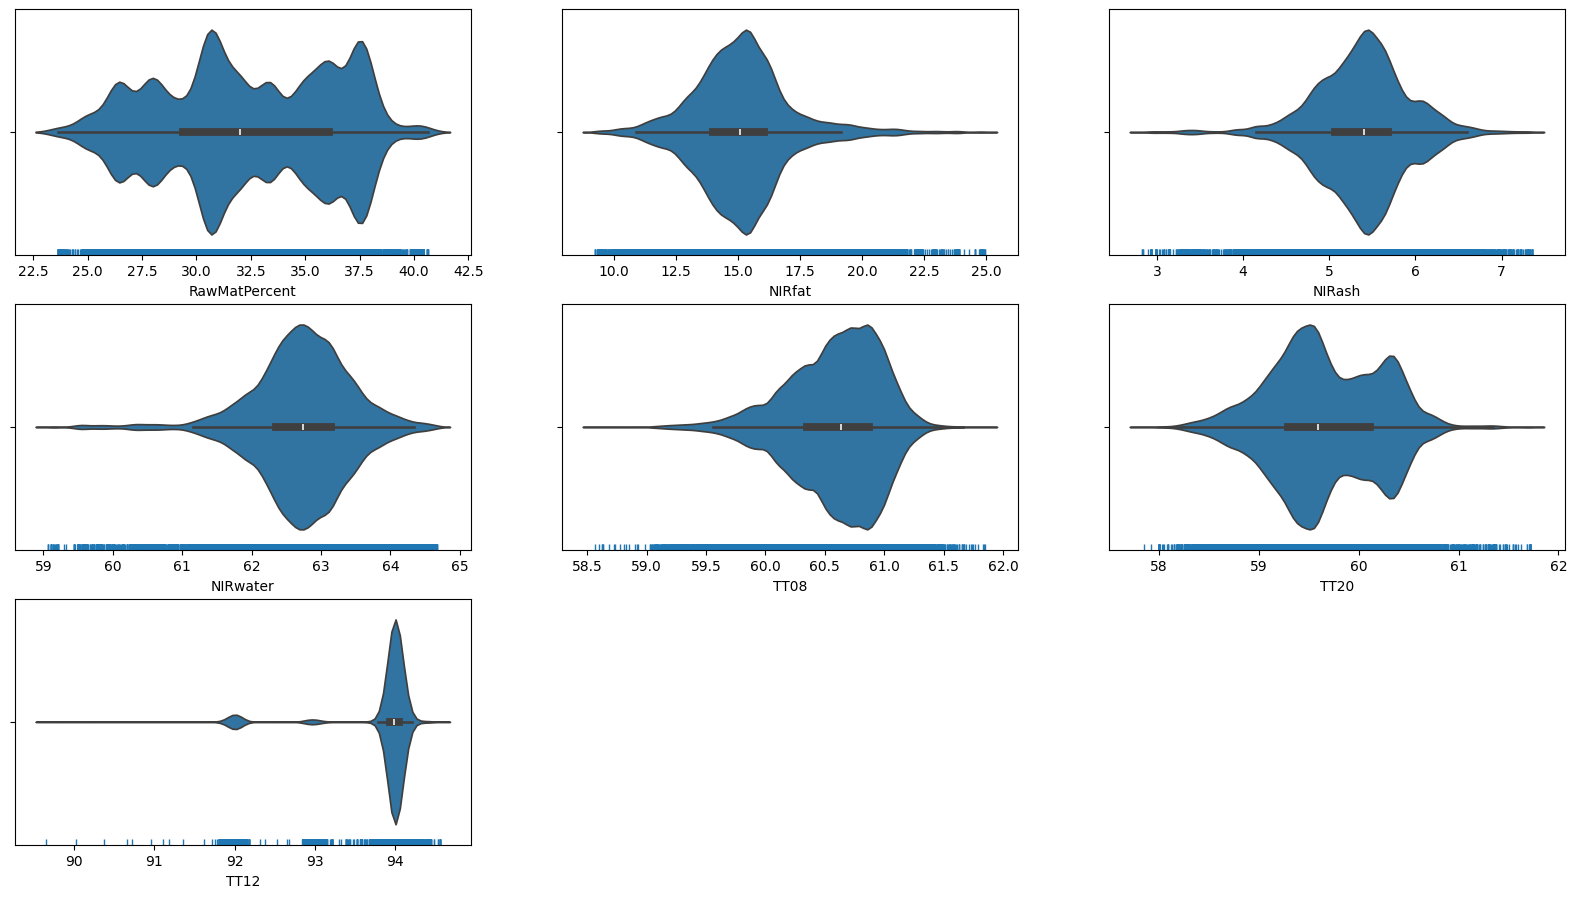

In [112]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(prediktor_data_ekstrem.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), prediktor_data_ekstrem):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = prediktor_data_ekstrem)
  sns.rugplot(x=prediktor_data_ekstrem[indeks])
  i += 1

Informasjon om hele datasett ekskludert ekstrem data

In [122]:
# Ekskluderer ektreme observasjoner fra behandlet data
behandlet_data_ekstrem = behandlet_data.loc[prediktor_data_ekstrem.index]

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(behandlet_data_ekstrem.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29047 entries, 2022-10-31 17:37:00 to 2023-06-14 01:05:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   29047 non-null  int64  
 1   EnzymeType_A2   29047 non-null  int64  
 2   EnzymeType_B    29047 non-null  int64  
 3   EnzymeType_C    29047 non-null  int64  
 4   EnzymeType_D    29047 non-null  int64  
 5   EnzymeType_E    29047 non-null  int64  
 6   RawMatPercent   29047 non-null  float64
 7   NIRfat          29047 non-null  float64
 8   NIRash          29047 non-null  float64
 9   NIRwater        29047 non-null  float64
 10  TT08            29047 non-null  float64
 11  TT20            29047 non-null  float64
 12  TT12            29047 non-null  float64
 13  Collagen        87 non-null     float64
 14  Mw              458 non-null    float64
 15  SmallMolecules  458 non-null    float64
 16  BrixAdjuste

# Undersøkelse av ekstrem data

Undersøker de ekstreme observasjonene

In [123]:
# Filtrerer ut ekstrem data
ekstrem_data =  behandlet_data.drop(behandlet_data_ekstrem.index)

# Data etter felles inspeksjon
print("Data etter felles inspeksjon:")
print(ekstrem_data.info())

Data etter felles inspeksjon:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 89 entries, 2022-11-09 06:37:00 to 2023-06-14 01:06:00
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   EnzymeType_A1   89 non-null     int64  
 1   EnzymeType_A2   89 non-null     int64  
 2   EnzymeType_B    89 non-null     int64  
 3   EnzymeType_C    89 non-null     int64  
 4   EnzymeType_D    89 non-null     int64  
 5   EnzymeType_E    89 non-null     int64  
 6   RawMatPercent   89 non-null     float64
 7   NIRfat          89 non-null     float64
 8   NIRash          89 non-null     float64
 9   NIRwater        89 non-null     float64
 10  TT08            89 non-null     float64
 11  TT20            89 non-null     float64
 12  TT12            89 non-null     float64
 13  Collagen        2 non-null      float64
 14  Mw              2 non-null      float64
 15  SmallMolecules  2 non-null      float64
 16  BrixAdjusted  

Violin plot

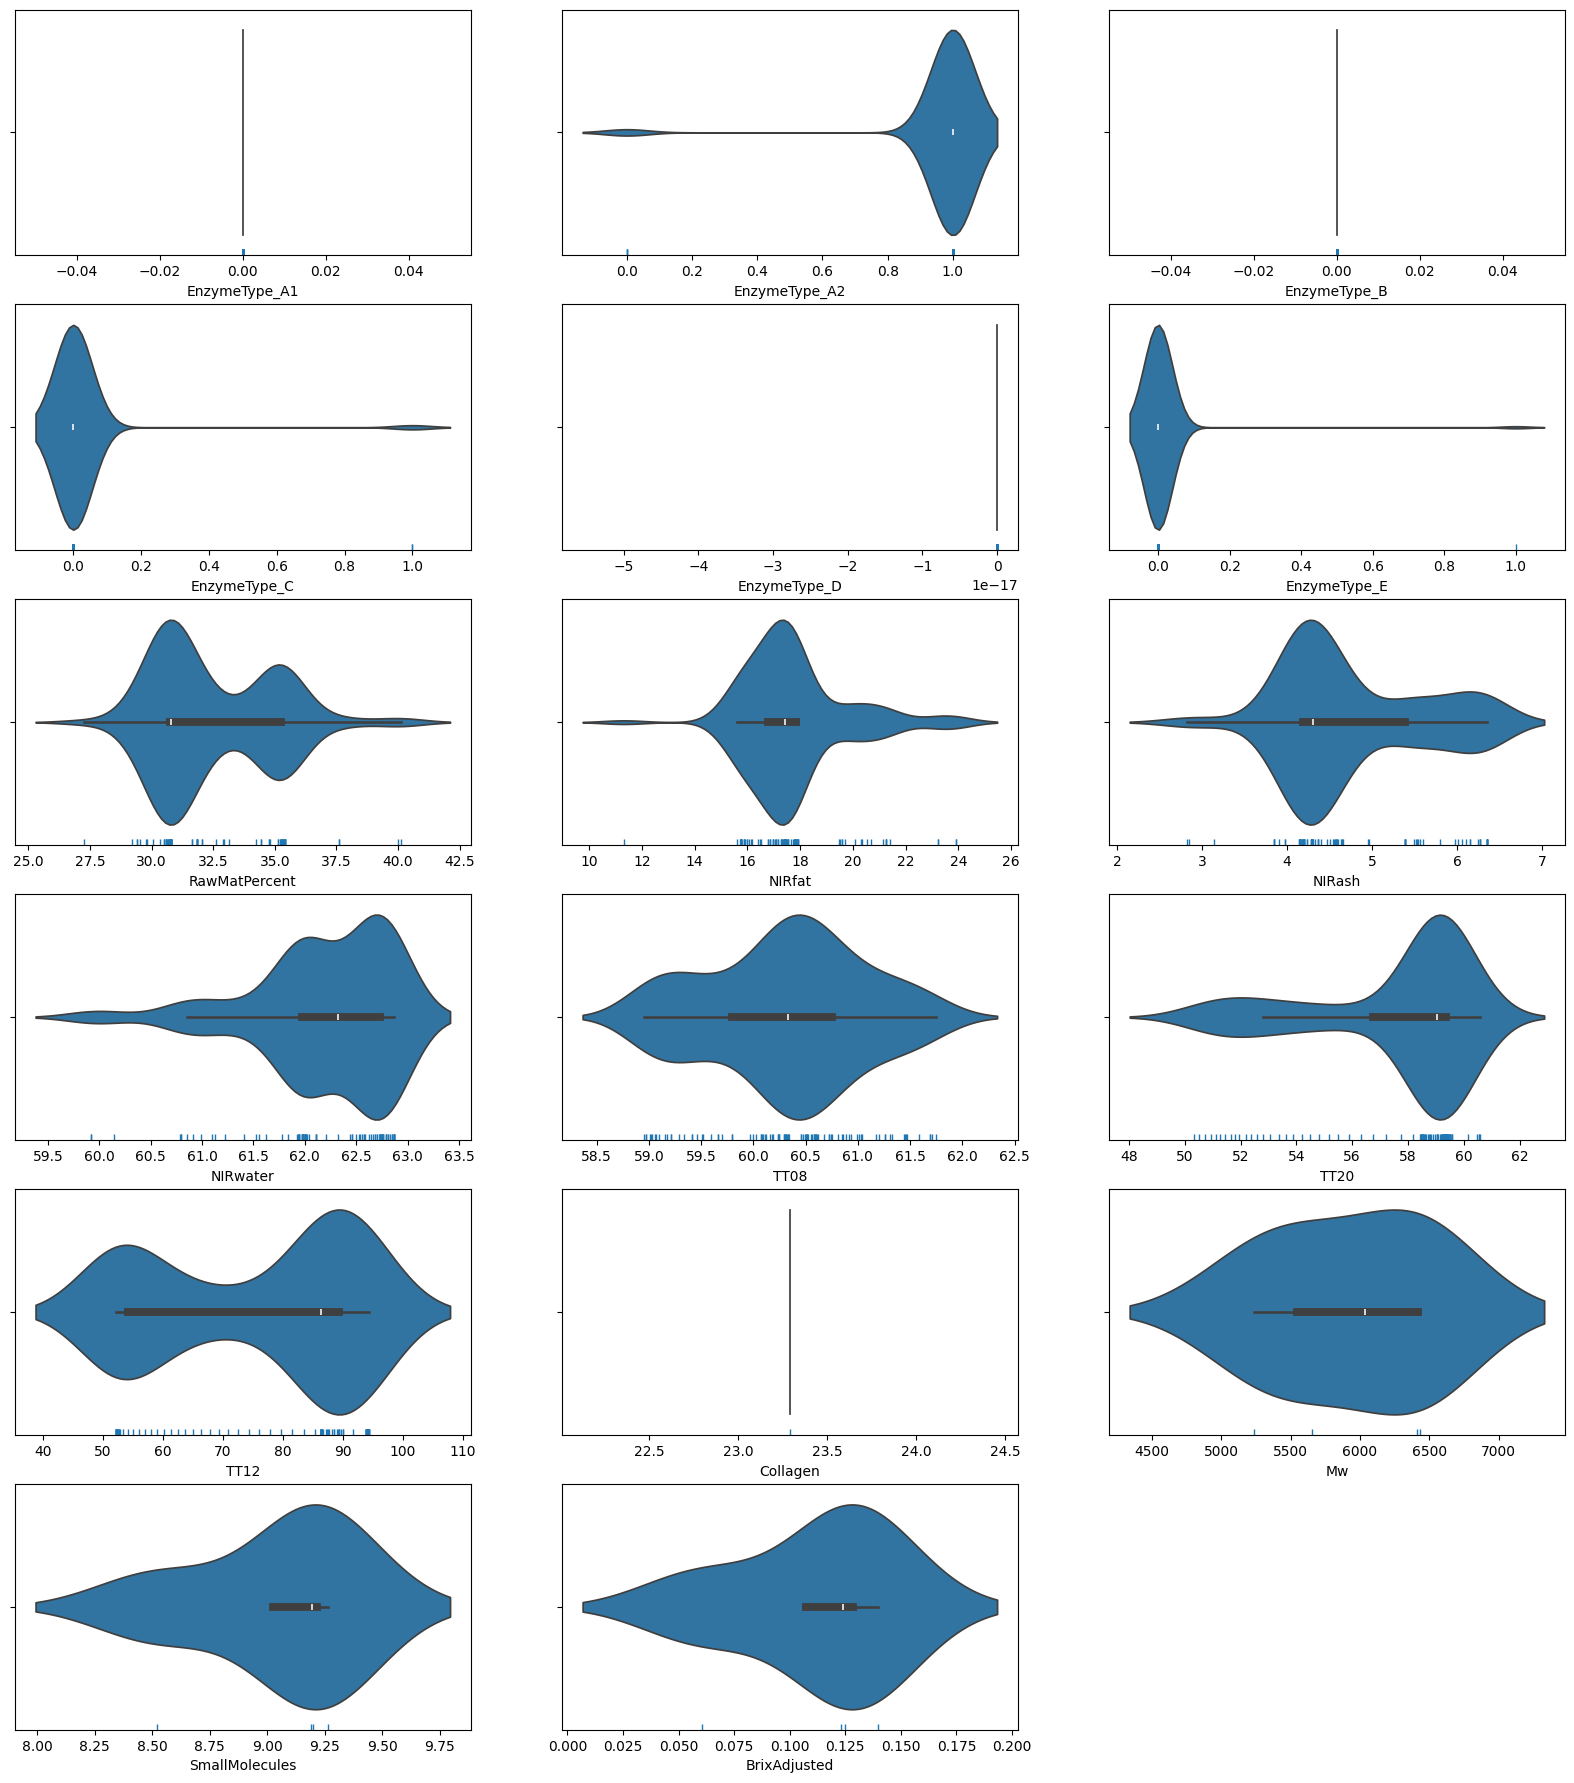

In [82]:
fig = plt.figure(figsize=(20,30))
antall_kolonnner = len(ekstrem_data.columns)
rute_nett = fig.add_gridspec(8,3)

n = 0
for nummer, indeks in zip(range(antall_kolonnner), ekstrem_data):
  if nummer % 3 == 0:
    n += 1
    i = 0
  ax = fig.add_subplot(rute_nett[n,i])
  sns.violinplot(x=indeks, data = ekstrem_data)
  sns.rugplot(x=ekstrem_data[indeks])
  i += 1

Undersøker markert data

In [120]:
# Filtrerer ut markert data fra datasett
ekstrem_data_filtrert = ekstrem_data.dropna(subset=['Mw'])
ekstrem_data_filtrert

,EnzymeType_A1,EnzymeType_A2,EnzymeType_B,EnzymeType_C,EnzymeType_D,EnzymeType_E,RawMatPercent,NIRfat,NIRash,NIRwater,TT08,TT20,TT12,Collagen,Mw,SmallMolecules,BrixAdjusted
sampleID,,,,,,,,,,,,,,,,,
2022-12-01 12:50:00,0,1,0,0,0,0,34.801911,17.842532,5.381879,62.006226,60.52561,59.33290,86.508825,23.29,5235.432713,9.264557,0.060342
2022-12-13 09:55:00,0,1,0,0,0,0,31.774826,21.250747,3.851002,60.754326,61.38824,59.52006,93.889110,28.98,6298.379432,8.787621,0.125886


Lagring av data behandlet for ekstreme verdier som csv

In [124]:
behandlet_data_ekstrem.to_csv('/content/drive/MyDrive/MasterV24/Bioco_data/ekstremverdi_data_behandlet_bioco_data.csv')